# Lesson 6 Assignment - Video Store Data Analysis

## Author - Connor Higgins

### Background
Consider the data collected by a hypothetical video store for 50 regular customers.

This data consists of a table which, for each customer, records the following attributes:
* Gender
* Income
* Age
* Rentals - Total number of video rentals in the past year
* Avg. per visit - Average number of video rentals per visit during the past year
* Incidentals - Whether the customer tends to buy incidental items such as refreshments when renting a video
* Genre - The customer's preferred movie genre

#### Obtaining Dataset

In [1]:
# Data set contains 600 rows and 11 columns.
URL = "https://library.startlearninglabs.uw.edu/DATASCI420/Datasets/Video_Store.csv"

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
np.random.seed(42)

In [3]:
# Reading in csv as dataframe
df = pd.read_csv(URL)
print('Video_Store.csv')
print(df.info())
df.head(10)

Video_Store.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 8 columns):
Cust ID          50 non-null int64
Gender           50 non-null object
Income           50 non-null int64
Age              50 non-null int64
Rentals          50 non-null int64
Avg Per Visit    50 non-null float64
Incidentals      50 non-null object
Genre            50 non-null object
dtypes: float64(1), int64(4), object(3)
memory usage: 3.2+ KB
None


,Cust ID,Gender,Income,Age,Rentals,Avg Per Visit,Incidentals,Genre
0,1,M,45000,25,27,2.5,Yes,Action
1,2,F,54000,33,12,3.4,No,Drama
2,3,F,32000,20,42,1.6,No,Comedy
3,4,F,59000,70,16,4.2,Yes,Drama
4,5,M,37000,35,25,3.2,Yes,Action
5,6,M,18000,20,33,1.7,No,Action
6,7,F,29000,45,19,3.8,No,Drama
7,8,M,74000,25,31,2.4,Yes,Action
8,9,M,38000,21,18,2.1,No,Comedy
9,10,F,65000,40,21,3.3,No,Drama


### Data Preparation

In [4]:
# Splitting the Age attribute into 4 bins with a near-equal number of samples (Age Group)
df['Age Group'] = pd.qcut(df['Age'], q=4)
df['Age Group'].replace({pd.Interval(14.999, 22.0, closed='right'): '15-22',
                         pd.Interval(22.0, 30.0, closed='right'): '23-30',
                         pd.Interval(30.0, 37.5, closed='right'): '31-37',
                         pd.Interval(37.5, 70.0, closed='right'): '38-70'}, inplace=True)
df['Age Group'].value_counts().sort_index()

15-22    14
23-30    12
31-37    11
38-70    13
Name: Age Group, dtype: int64

In [5]:
# MinMax Scaling Age feature
from sklearn.preprocessing import MinMaxScaler
m_scaler = MinMaxScaler()
df['Age'] = m_scaler.fit_transform(df['Age'].values.astype(float).reshape(-1,1))
df[['Age']].describe()

,Age
count,50.000000
mean,0.301091
std,0.218187
min,0.000000
25%,0.127273
50%,0.272727
75%,0.409091
max,1.000000


In [6]:
# MinMax Scaling Income feature
df['Income Scaled'] = m_scaler.fit_transform(df['Income'].values.astype(float).reshape(-1,1))
df[['Income', 'Income Scaled']].describe()

,Income,Income Scaled
count,50.000000,50.000000
mean,42300.000000,0.469318
std,21409.753642,0.243293
min,1000.000000,0.000000
25%,26750.000000,0.292614
50%,41000.000000,0.454545
75%,56750.000000,0.633523
max,89000.000000,1.000000


In [7]:
# Standardizing Rentals feature using z-score normalization (Rentals zScaled) and minmax (Rentals Scaled)
from sklearn.preprocessing import StandardScaler
s_scaler = StandardScaler()
df['Rentals zScaled'] = s_scaler.fit_transform(df['Rentals'].values.astype(float).reshape(-1,1))
df['Rentals Scaled'] = m_scaler.fit_transform(df['Rentals'].values.astype(float).reshape(-1,1))
df[['Rentals', 'Rentals Scaled', 'Rentals zScaled']].describe()

,Rentals,Rentals Scaled,Rentals zScaled
count,50.000000,50.000000,5.000000e+01
mean,26.240000,0.442051,1.487699e-16
std,10.027635,0.257119,1.010153e+00
min,9.000000,0.000000,-1.736704e+00
25%,19.000000,0.256410,-7.293349e-01
50%,25.000000,0.410256,-1.249137e-01
75%,32.750000,0.608974,6.557970e-01
max,48.000000,1.000000,2.192034e+00


In [8]:
# Discretizing original Income feature using High = 60K+, Mid = 25K-59K, and Low = less than $25K
bins = pd.IntervalIndex.from_tuples([(0, 24999), (24999, 59999), (59999, 90000)])
df['Income Group'] = pd.cut(df['Income'], bins)
df['Income Group'].replace({pd.Interval(0, 24999, closed='right'): 'Low',
                            pd.Interval(24999, 59999, closed='right'): 'Mid',
                            pd.Interval(59999, 90000, closed='right'): 'High'}, inplace=True)
df['Income Group'].value_counts()

Mid     29
Low     11
High    10
Name: Income Group, dtype: int64

In [9]:
# Grouping Categorical Variables
dfcatcols = df.select_dtypes(include=["object"])
dfcatcols.head()

,Gender,Incidentals,Genre,Age Group,Income Group
0,M,Yes,Action,23-30,Mid
1,F,No,Drama,31-37,Mid
2,F,No,Comedy,15-22,Mid
3,F,Yes,Drama,38-70,Mid
4,M,Yes,Action,31-37,Mid


In [10]:
# Encoding categorical features using pd.get_dummies()
dfcatcols = pd.get_dummies(dfcatcols)
dfcatcols.head()

,Gender_F,Gender_M,Incidentals_No,Incidentals_Yes,Genre_Action,Genre_Comedy,Genre_Drama,Age Group_15-22,Age Group_23-30,Age Group_31-37,Age Group_38-70,Income Group_High,Income Group_Low,Income Group_Mid
0,0,1,0,1,1,0,0,0,1,0,0,0,0,1
1,1,0,1,0,0,0,1,0,0,1,0,0,0,1
2,1,0,1,0,0,1,0,1,0,0,0,0,0,1
3,1,0,0,1,0,0,1,0,0,0,1,0,0,1
4,0,1,0,1,1,0,0,0,0,1,0,0,0,1


In [11]:
# Recombining numeric and categorical features
dfnumcols = df.select_dtypes(exclude=["object"])
df = pd.concat([dfnumcols, dfcatcols], axis=1)
df.head()

,Cust ID,Income,Age,Rentals,Avg Per Visit,Income Scaled,Rentals zScaled,Rentals Scaled,Gender_F,Gender_M,...,Genre_Action,Genre_Comedy,Genre_Drama,Age Group_15-22,Age Group_23-30,Age Group_31-37,Age Group_38-70,Income Group_High,Income Group_Low,Income Group_Mid
0,1,45000,0.181818,27,2.5,0.500000,0.076560,0.461538,0,1,...,1,0,0,0,1,0,0,0,0,1
1,2,54000,0.327273,12,3.4,0.602273,-1.434493,0.076923,1,0,...,0,0,1,0,0,1,0,0,0,1
2,3,32000,0.090909,42,1.6,0.352273,1.587613,0.846154,1,0,...,0,1,0,1,0,0,0,0,0,1
3,4,59000,1.000000,16,4.2,0.659091,-1.031546,0.179487,1,0,...,0,0,1,0,0,0,1,0,0,1
4,5,37000,0.363636,25,3.2,0.409091,-0.124914,0.410256,0,1,...,1,0,0,0,0,1,0,0,0,1


In [12]:
# Reordering df columns, dropping several redudant features, and renaming remaining features
column_reorder = ['Cust ID', 'Incidentals_No', 'Rentals', 'Rentals Scaled',
                  'Rentals zScaled', 'Income', 'Income Scaled', 'Age',
                  'Avg Per Visit', 'Gender_F', 'Genre_Action', 'Genre_Comedy',
                  'Genre_Drama', 'Age Group_15-22', 'Age Group_23-30', 'Age Group_31-37',
                  'Age Group_38-70', 'Income Group_High', 'Income Group_Mid', 'Income Group_Low']
df = df[column_reorder]
df.rename(index=str, columns={'Incidentals_No': 'Incidentals', 'Gender_F': 'Gender'}, inplace=True)

### Dataset Analysis
#### Correlations

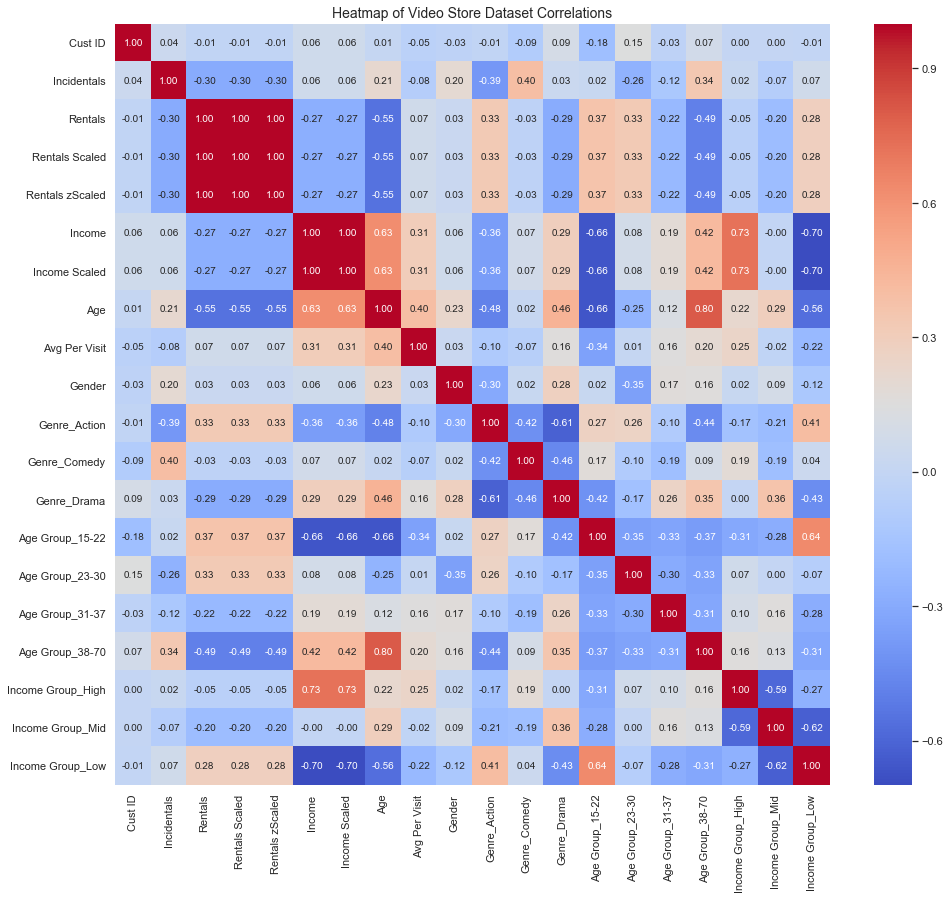

In [13]:
# Plotting df correlations as a heatmap
plt.figure(figsize=(16,14))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Heatmap of Video Store Dataset Correlations', fontdict={'fontsize': 14})
plt.show()

#### Figure 1 | Heatmap of Video Store Dataset Correlations
The Pearson correlation coefficient for each attribute pair, plotted as a heatmap. Looking at the two target attributes, Incidentals and Rentals, some patterns are noticeable: purchasing Incidentals is negatively correlated to the number of rentals purchased (-0.3), negatively correlated to those who prefer Action films (-0.39), positively correlated to those who prefer Comedy films (0.4), and positively correlated to customers between the ages of 38 and 70 (0.34). In contrast, purchasing Rentals is negatively correlated to Age overall (-0.55), being positively correlated with 15-22 year-olds (0.37) and 23-30 year-olds (0.33) but negatively correlated with 38-70 year-olds (-0.49). Additionally, Rental purchasing is positively correlated to those who prefer Action films (0.33) and negatively correlated with those who prefer Drama (-0.29). 

Overall, we can hypothesize that the Video Store has at least two groups of paying customers: one group tends to prefer fewer rentals and an incidental, while another tends to prefer no incidental and more rentals. The former group tends to be older and prefer Comedy, while the latter group tends to be younger and prefer Action. None of these trends, however, are particularly strong except perhaps the young age of the latter group (Age, -0.55).

### Feature Group Comparisons - Good Customers v. All Customers

In [14]:
# Obtaining general statistics for full dataset (df_gstat)
df_gstat = df.describe().T
df_gstat.columns = [str(col) + '_ac' for col in df_gstat.columns]

# Defining dfgoodcust and obtaining general statistics (dfgoodcust_gstat)
dfgoodcust = df[df['Rentals'] >= 30].copy()
dfgoodcust_gstat = dfgoodcust.describe().T
dfgoodcust_gstat.columns = [str(col) + '_gc' for col in dfgoodcust_gstat.columns]

# Compbining df_gstat and dfgoodcust_gstat for easier comparison of statistics
gstat_comparison = pd.concat([df_gstat, dfgoodcust_gstat], axis=1)
newcol_order = [0, 8, 1, 9, 2, 10, 3, 11, 4, 12, 5, 13, 6, 14, 7, 15]
gstat_comparison = gstat_comparison[gstat_comparison.columns[newcol_order]]
gstat_comparison.style.format("{:.2f}")

,count_ac,count_gc,mean_ac,mean_gc,std_ac,std_gc,min_ac,min_gc,25%_ac,25%_gc,50%_ac,50%_gc,75%_ac,75%_gc,max_ac,max_gc
Cust ID,50.00,18.00,25.50,26.83,14.58,15.05,1.00,3.00,13.25,15.75,25.50,26.50,37.75,39.00,50.00,50.00
Incidentals,50.00,18.00,0.48,0.44,0.50,0.51,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00
Rentals,50.00,18.00,26.24,37.28,10.03,5.85,9.00,30.00,19.00,32.25,25.00,36.50,32.75,41.75,48.00,48.00
Rentals Scaled,50.00,18.00,0.44,0.73,0.26,0.15,0.00,0.54,0.26,0.60,0.41,0.71,0.61,0.84,1.00,1.00
Rentals zScaled,50.00,18.00,0.00,1.11,1.01,0.59,-1.74,0.38,-0.73,0.61,-0.12,1.03,0.66,1.56,2.19,2.19
Income,50.00,18.00,42300.00,37666.67,21409.75,23126.25,1000.00,2000.00,26750.00,19500.00,41000.00,31500.00,56750.00,56000.00,89000.00,74000.00
Income Scaled,50.00,18.00,0.47,0.42,0.24,0.26,0.00,0.01,0.29,0.21,0.45,0.35,0.63,0.62,1.00,0.83
Age,50.00,18.00,0.30,0.18,0.22,0.15,0.00,0.00,0.13,0.09,0.27,0.15,0.41,0.25,1.00,0.58
Avg Per Visit,50.00,18.00,2.75,2.78,0.90,0.93,1.10,1.60,2.12,2.15,2.75,2.55,3.38,3.38,4.70,4.70
Gender,50.00,18.00,0.48,0.56,0.50,0.51,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00


#### Figure 2 | General Statistics for both All Customer and Good Customer Groups
The mean, standard deviation, min, max, and quartiles for both all customer (ac, df) and good customer (gc, dfgoodcust) groups, where good customers are defined as having 30 or more rentals. Good Customers represent 36% (N=18) of all customers (N=50). Even without further plotting, several differences are apparent between the two groups: Good Customers, on average, tend to be less wealthy (0.47 v. 0.42), younger (0.30 v. 0.18), female (0.48 v. 0.56), and more interested in Comedy (0.28 v. 0.43) and Drama (0.22 v. 0.49) films than the general customer.

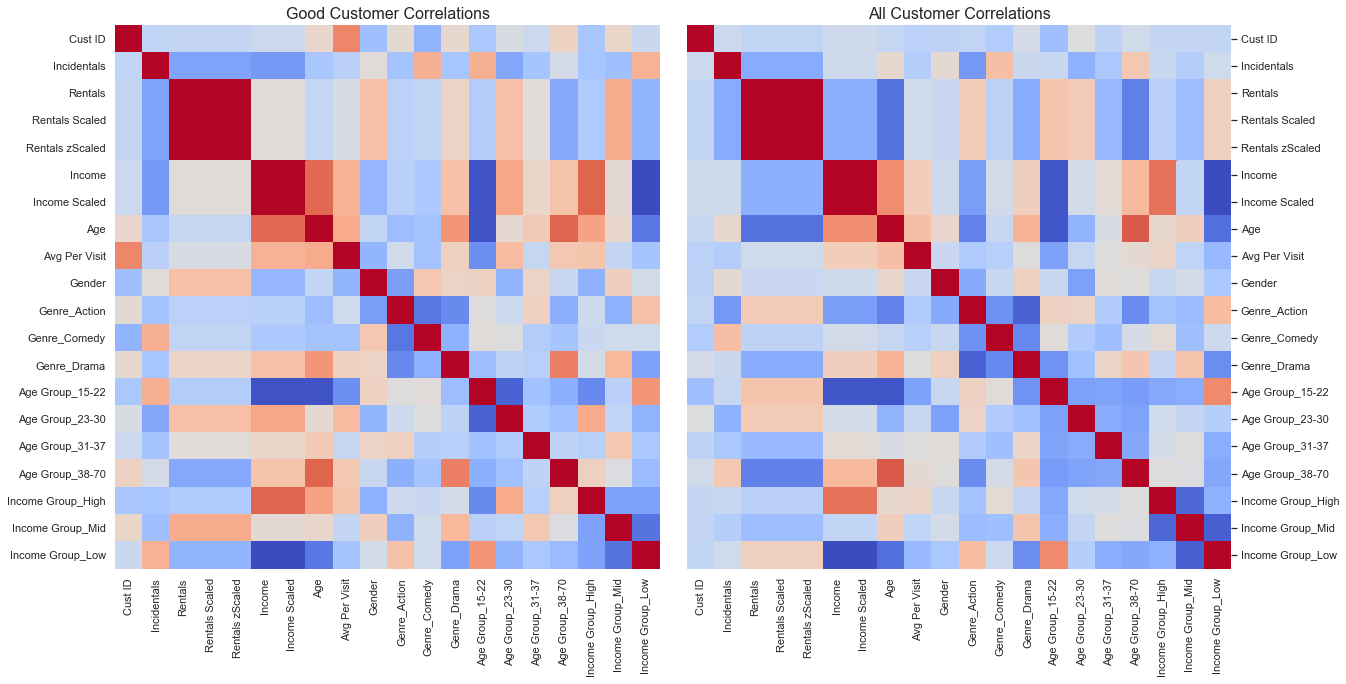

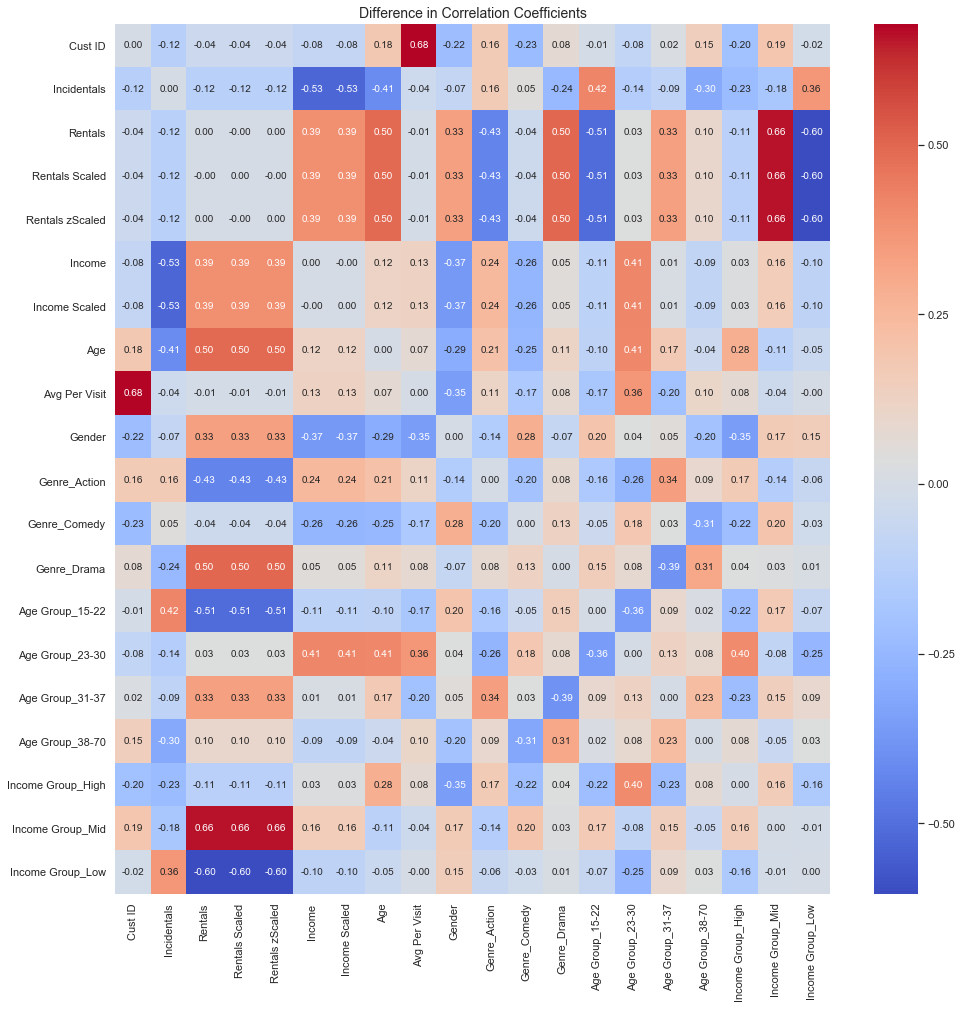

In [15]:
# Plotting df and dfgoodcust heatmaps side-by-side, for quick comparison
plt.figure(figsize=(20,10))
ax1 = plt.subplot(121)
sns.heatmap(dfgoodcust.corr(), cmap='coolwarm', ax=ax1, cbar=False)
ax1.set_title('Good Customer Correlations', fontdict={'fontsize': 16})
ax2 = plt.subplot(122)
sns.heatmap(df.corr(), cmap='coolwarm', ax=ax2, cbar=False)
ax2.set_title('All Customer Correlations', fontdict={'fontsize': 16})
ax2.yaxis.tick_right()
plt.yticks(rotation=0)
plt.subplots_adjust(wspace=0.05)
plt.show()

# Plotting difference of dfgoodcust.corr() and df.corr() as a heatmap
plt.figure(figsize=(16,16))
sns.heatmap(dfgoodcust.corr()-df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Difference in Correlation Coefficients', fontdict={'fontsize': 14})
plt.show()

#### Figure 3 | Heatmaps of Good Customer and All Customer Correlations, along with Heatmap of Difference
Both Good Customer and All Customer Correlations plotted as heatmaps side-by-side for visual comparison with a heatmap of their difference. For the Incidentals attribute, there was a stronger negative correlation with Income (-0.53) and Age (-0.41) and a stronger positive correlation with Age-Group (+0.42) and Income Group_Low (+0.36). As such, the Good Customer group builds upon many of the trends apparent within the Incidentals attribute for the original dataset (Figure 1).

For the Rentals attribute, any positive correlation with Age (+0.50), Income (+0.39) have disappeared, as has the negative correlation with Age Group 31-37 (+0.33). Instead, we see a sronger positive correlation with being female (Gender, +0.33), preferring Drama films (+0.50), and being part of Income Group_Mid (+0.66). Additionally there is stronger negative correlation with Age Group 15-22 (-0.51), preferring Action Movies (-0.43), and being part of Income Group_Low (-0.6).

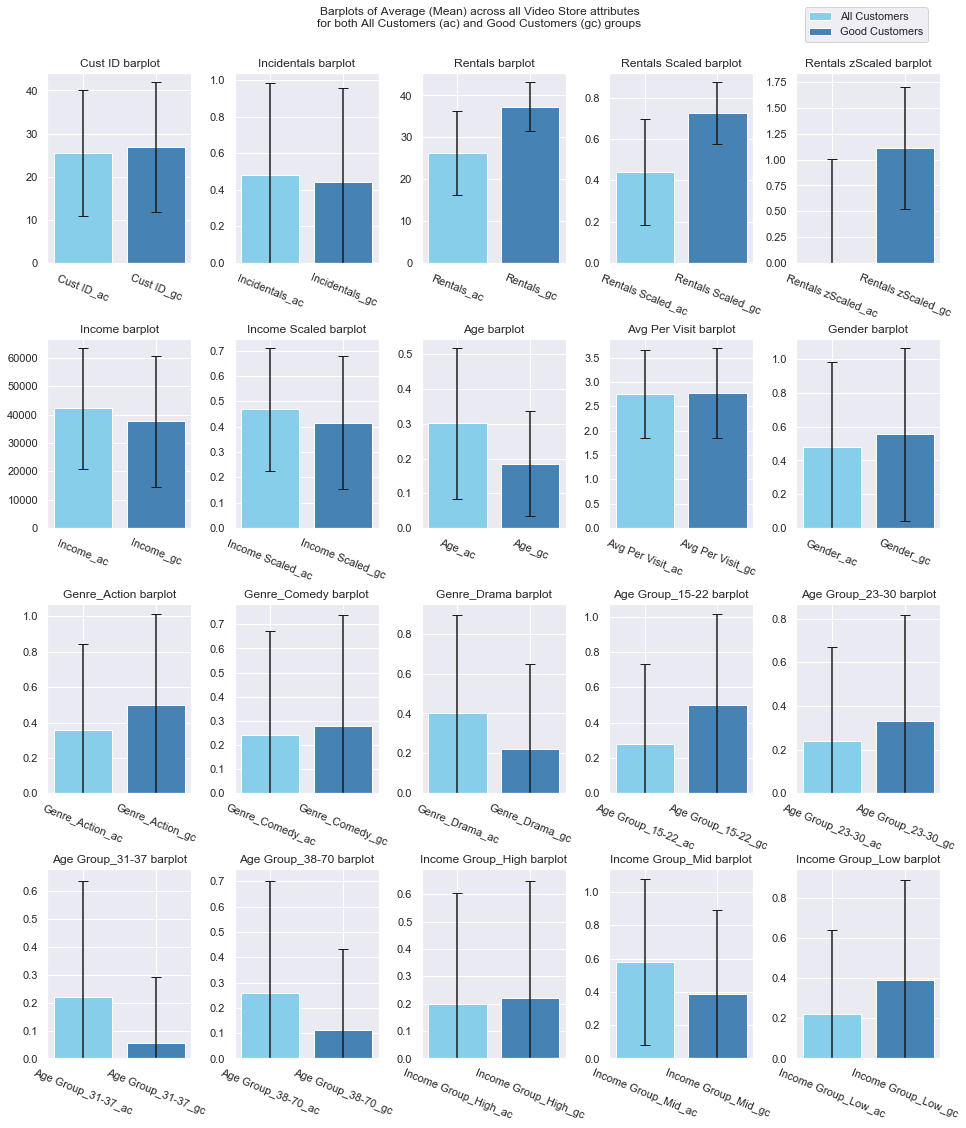

,ac_mean,ac_std,gc_mean,gc_std,p-val,t-stat
Cust ID,25.5,14.5774,26.8333,15.0499,0.74246906,-0.3300
Incidentals,0.48,0.504672,0.444444,0.51131,0.79917761,0.2554
Rentals,26.24,10.0276,37.2778,5.84914,0.00004110,-4.3954
Rentals Scaled,0.442051,0.257119,0.725071,0.149978,0.00004110,-4.3954
Rentals zScaled,1.4877e-16,1.01015,1.11191,0.589224,0.00004110,-4.3954
Income,42300,21409.8,37666.7,23126.3,0.44349910,0.7709
Income Scaled,0.469318,0.243293,0.416667,0.262798,0.44349910,0.7709
Age,0.301091,0.218187,0.184848,0.15074,0.04107794,2.0835
Avg Per Visit,2.748,0.898125,2.77778,0.92708,0.90515091,-0.1196
Gender,0.48,0.504672,0.555556,0.51131,0.58908896,-0.5428


In [16]:
# Further Anaylsis: Barplots and ttests
def barplot_ttest_multi_df(df1, df2, df1labels, df2labels, figsize=(16,23),
                           subplot_dim=(5,5), subplot_adj=None, legend_adj=None):
    ''' 
    Returns a series of bar subplots comparing all columns within df1 and df2,
    as well as a dataframe containing column t-test statistics and general statistics.
    '''
    
    # Plotting all column pairs as barplots
    cols = list(df1.columns) 
    plt.figure(figsize=figsize)
    for col in cols:
        ax = plt.subplot(subplot_dim[0], subplot_dim[1], cols.index(col)+1)
        pl1 = plt.bar('_'.join([col, df1labels[0]]), df1[col].mean(), yerr=df1[col].std(),
                      capsize=5, color='skyblue')
        pl2 = plt.bar('_'.join([col, df2labels[0]]), df2[col].mean(), yerr=df2[col].std(),
                      capsize=5, color='steelblue')
        ax.set_title(f'{col} barplot')
        plt.xticks(rotation=-22)
        ax.set_ylim(top=None, bottom=0)
    
    if subplot_adj:
        plt.subplots_adjust(wspace=subplot_adj[0], hspace=subplot_adj[1])
    if legend_adj:
        plt.figlegend((pl1, pl2), (df1labels[1], df2labels[1]),
                      bbox_to_anchor=(legend_adj[0], legend_adj[1]))
    else:
        plt.figlegend((pl1, pl2), ('All Customers', 'Good Customers'))
        
    plt.suptitle('Barplots of Average (Mean) across all Video Store attributes\n'
                 f'for both {df1labels[1]} ({df1labels[0]}) and '
                 f'{df2labels[1]} ({df2labels[0]}) groups', y=0.92)
    plt.show()
    
    # Obtaining t-stat, p-val, mean, and stdev for all columns in both datasets
    ttst_res = {}
    for col in cols:
        t, p = ss.ttest_ind(df1[col], df2[col])
        ttst_res.update({col : {'t-stat': f'{t:0.4f}', 'p-val': f'{p:0.8f}',
                                f'{df1labels[0]}_mean': df1[col].mean(),
                                f'{df2labels[0]}_mean': df2[col].mean(),
                                f'{df1labels[0]}_std': df1[col].std(),
                                f'{df2labels[0]}_std': df2[col].std()}})
        ttst_df = pd.DataFrame(data=ttst_res).T
    return ttst_df

# Creating barplots to compare attributes across All Customer and Good Customer Groups   
barplot_ttest_multi_df(df, dfgoodcust, ['ac', 'All Customers'], ['gc', 'Good Customers'],
                       subplot_adj=[0.3, 0.4], legend_adj=[0.81, 0.68])

#### Figure 4 | Barplots of Columns of Good Customer and All Customer Datasets, along with t-stat, p-val, and general column statistics
In order to better view the results presented in Figure 2, a series of barplots were created, each representing the average (mean) of each attribute for both All Customer (ac, light blue) and Good Customer (gc, dark blue) groups. Furthermore, t-tests were conducted between groups for each attribute. As Good Customer entries were not removed from the original dataset, the sharing of entries reduces the t-test's performance; even still, Age was determined to be significantly different (t=2.08, p<0.05), with the average Good Customer being much younger than the average customer. This is reflected in the near significance of Age Group_15-22 (t=-1.70, p=0.09). Other near siginficance results include Income Group_Mid (t=1.39, p=0.17), which was represented more in the All Customers dataset and Income Group_Low (t=1.39, p=0.17), which was represented more in the Good Customers dataset. 

### Feature Group Comparisons - Incidentals_Yes v. Incidentals_No

<i>Suppose that because of the high profit margin, the store would like to increase the sales of incidentals. Based on your observations in previous parts discuss how this could be accomplished (e.g., Should customers with specific characteristics be targeted? Should certain types of movies be preferred? etc.).</i>

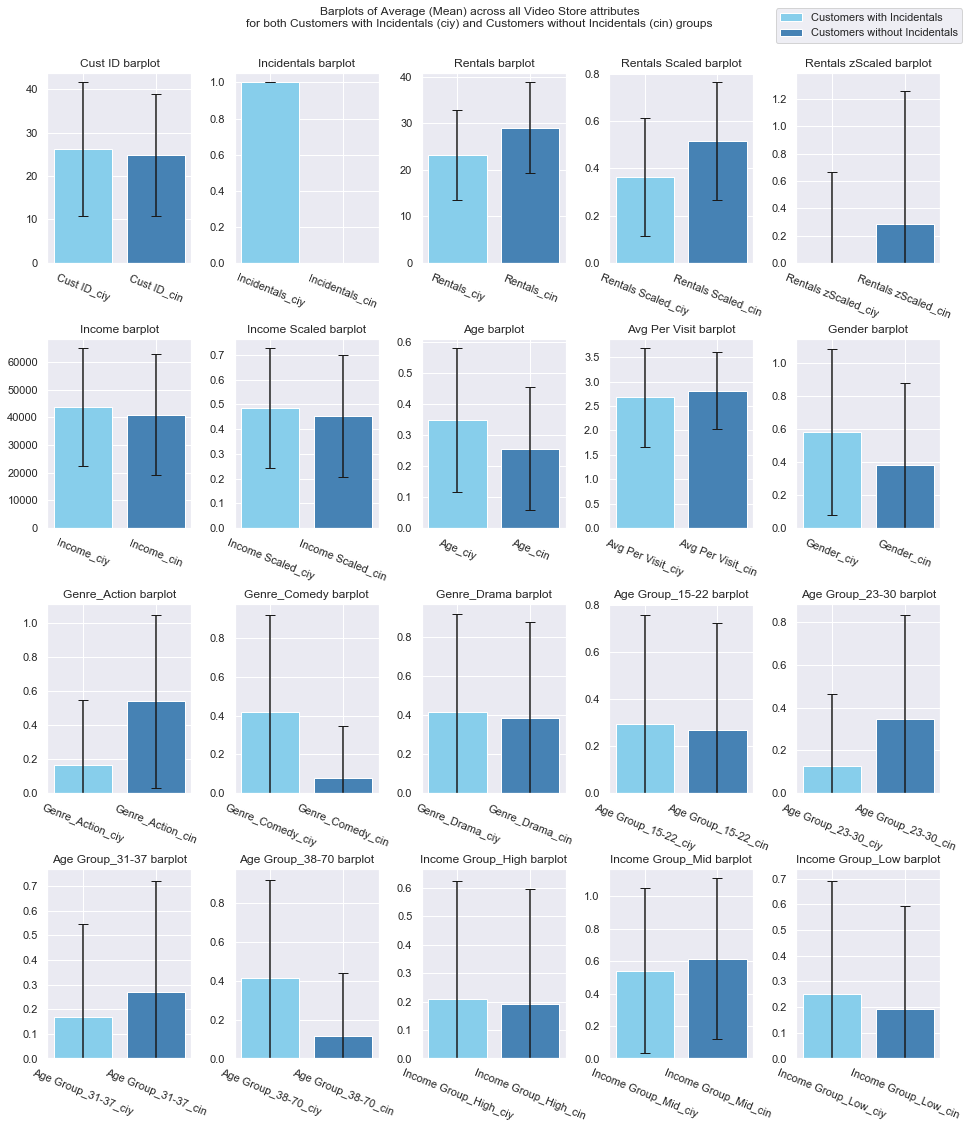

,cin_mean,cin_std,ciy_mean,ciy_std,p-val,t-stat
Cust ID,24.9231,14.0198,26.125,15.4366,0.77417715,0.2885
Incidentals,0,0,1,0,0.00000000,inf
Rentals,29.0769,9.67852,23.1667,9.66692,0.03591856,-2.1585
Rentals Scaled,0.514793,0.248167,0.363248,0.24787,0.03591856,-2.1585
Rentals zScaled,0.285783,0.974984,-0.309598,0.973815,0.03591856,-2.1585
Income,41000,21716.4,43708.3,21446.6,0.65960684,0.4432
Income Scaled,0.454545,0.246777,0.485322,0.243711,0.65960684,0.4432
Age,0.256643,0.197728,0.349242,0.232963,0.13528052,1.5192
Avg Per Visit,2.81538,0.78368,2.675,1.01991,0.58607028,-0.5482
Gender,0.384615,0.496139,0.583333,0.50361,0.16652709,1.4048


In [17]:
# Creating Incidentals_Yes and Incidentals_No datasets
Incidentals_Yes = df[df['Incidentals'] == 1].copy()
Incidentals_No = df[df['Incidentals'] == 0].copy()

# Creating barplots to compare attributes across Incidentals_Yes and Incidentals_No
barplot_ttest_multi_df(Incidentals_Yes, Incidentals_No,
                       ['ciy', 'Customers with Incidentals'],
                       ['cin', 'Customers without Incidentals'],
                       subplot_adj=[0.3, 0.4], legend_adj=[0.84, 0.68])

#### Figure 5 | Barplots of Columns of Incidental No and Incidental Yes Datasets, along with t-stat, p-val, and general column statistics
Using the same function as with Figure 4, a series of barplots were created, each representing the average (mean) of each attribute for both Customers with Incidentals (ciy, light blue) and Customers without Incidentals (cin, dark blue). T-tests were also similarly conducted between groups for each attribute, yet with no sharing of entries between groups (N=24, N=26), allowing for better test performance. Several significant results included Rentals, where the Incidentals group purchased signficantly fewer rentals than the non-Incidentals group (t=-2.16, p<0.05); Genre_Action, where the Incidentals group preferred actions films far less than the non-Incidentals group (t=-2.91, p<0.01); Genre_Comedy, where the Incidentals group preferred comedy films far more than the non-Incidentals group (t=3.00, p<0.01); and Age Group_38-70, where the Incidentals group had significantly more people ages 38-70 than the non-Incidentals group (t=2.53, p<0.05).

As stated before, it appears as though there are at least two distinct groups of customers: those who purchase incidentals and fewer rentals and those who purchase no incidentals but more rentals. If we are looking to maximize the number of incidentals sold, results would suggest that offering a greater variety of comedy films could potentially attract more comedy-inclined customers, who are more inclined to purchase incidentals than their action or drama-inclined counterparts. Furthermore, as older customers (ages 38-70) are more likely to purchase incidentals, our video store should consider advertising discounts, rewards, or events targeted towards seniors. Offering more classic comedy films should also be considered.